# Multivariate-Time Series (MTS) Aware Manifold Forests 

**By: Adam Li and Chester Huynh**

In EEG/iEEG datasets for classification of a snapshot, each snapshot, $X_i = (C, T)$, where there are C channels and T time points of data. In the image-based MORF, $X_i$ is assumed to be correlated for nearby channels and timepoints (i.e. length and width of the image), but in multivariate time-series that is not the case necessarily. For example, channel Fp1 and Fp2 are not necessarily more correlated then Fp1 and Ot1. These are simply letters assigned to recording electrodes and are stacked in the data in no meaningful order generally.

Instead of using a ``Projection Matrix`` for your forest that assumes to sample nearby points, we impose a discontiguous sampling along the channel axis, but contiguous sampling along the time axis. So at each node of the tree, a random point in our data is selected, then it creates a contiguous patch in time (nearest time points) based on `patch_width_min` and `patch_width_max`. Then it will create a **discontiguous** patch in channels based on `patch_height_min` and `patch_height_max`, that selects a few other random channels to use. This forms the feature combination.

We believe this is more robust when it comes to classification in multivariate time-series.

## Simulation Experiment

We test this on simulated data:

A 3-dimensional multivariate Gaussian, $D = (D_1, D_2, D_3) \in \mathbb{R}^3$ is embedded into a 6-dimensional dataset where 
3 of the other dimensions are normal iid Gaussian noise. There are two classes of data, $\{1, 2\}$. 
The data to be  classified is $X_i \in \mathbb{R}^6$ with $Y \in \{1, 2\}$. The distinguishing 
signal between the two classes is embedded in the covariance matrix, $\Sigma$. The variances of the 
signal are equivalent between the two classes: $\Sigma^1_{ii} = \Sigma^2_{ii}$ for the covariance matrix of class 1 and 2. However, the
covariances between the different Gaussians is what differentiates the two classes. Furthermore, our 
data is structured such that: $X = [D_1, noise, D_2, noise, D_3, noise]^T$. 

This situation can be analagous to an EEG classification scenario. For example, one might try to decode movements from scalp EEG, but most likely the most informative channels are the ones recording from near the motor cortex, whereas the other signals are not correlated to the movement. In addition, the way we stack the channels may be arbitrary.

We test: what is the mean-squared-error (MSE) of the test set as a function of sample-size?

Next, we additionally demonstrate the robustness to dimensionality of the problem. We embed the 3-dimensional Gaussian into increasingly higher-dimensions of noise and we re-run the same experiment. We seek to answer: how robust is the classifier as a function of the dimensionality of the noise?

References
----------

Visual Examples of Contiguous Kernels:
https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.saama.com%2Fdifferent-kinds-convolutional-filters%2F&psig=AOvVaw1KSgQ0V39eN9S_JB6JAoGc&ust=1584819248892000&source=images&cd=vfe&ved=0CAIQjRxqFwoTCMCO4_rlqegCFQAAAAAdAAAAABAD

Visual Examples of Discontiguous Kernels:
https://www.google.com/url?sa=i&url=https%3A%2F%2Fwww.mdpi.com%2F2076-3417%2F10%2F5%2F1727%2Fhtm&psig=AOvVaw39o_oj3W8Lkbn-Pq6nbboy&ust=1584819310634000&source=images&cd=vfe&ved=0CAIQjRxqFwoTCNDuj5TmqegCFQAAAAAdAAAAABAD

In [1]:
%load_ext lab_black

In [2]:
cd ../../

ERROR:root:Cannot parse: 1:4: cd ../../
Traceback (most recent call last):
  File "/home/adam2392/Documents/morf-demo/.venv/lib/python3.8/site-packages/lab_black.py", line 218, in format_cell
    formatted_code = _format_code(cell)
  File "/home/adam2392/Documents/morf-demo/.venv/lib/python3.8/site-packages/lab_black.py", line 29, in _format_code
    return format_str(src_contents=code, mode=FileMode())
  File "/home/adam2392/Documents/morf-demo/.venv/lib/python3.8/site-packages/black/__init__.py", line 974, in format_str
    src_node = lib2to3_parse(src_contents.lstrip(), mode.target_versions)
  File "/home/adam2392/Documents/morf-demo/.venv/lib/python3.8/site-packages/black/__init__.py", line 1083, in lib2to3_parse
    raise exc from None
black.InvalidInput: Cannot parse: 1:4: cd ../../


/home/adam2392/Documents


In [3]:
import pandas as pd
from scipy import stats
import numpy as np
from pathlib import Path

import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline
import seaborn as sns

import pickle
import time
from tqdm import tqdm

from sklearn.model_selection import train_test_split

# comparative classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

# evaluation classifier
from rerf.rerfClassifier import rerfClassifier

import sys

print(sys.version)
import warnings

warnings.simplefilter("ignore")

%matplotlib inline
%load_ext autoreload
%autoreload 2

3.8.3 (default, May 19 2020, 18:47:26) 
[GCC 7.3.0]


In [4]:
seed = 12345

In [5]:
import numpy as np


def _generate_correlated_samples(n_samples: int, mu=None, cov=None, random_state=None):
    """Generate multi-variate Gaussian correlated examples.

    Parameters
    ----------
    n_samples : int
        The number of samples to generate.
    mu : np.ndarray
        The mean vector.
    cov : np.ndarray
        The covariance matrix. Note it must be Positive Definite.
    random_state : int
        The random seed.

    Returns
    -------
    y : np.ndarray
        [3, n_samples] is the returned correlated example.
    """
    # set a random seed for the samples
    if random_state is not None:
        np.random.seed(random_state)

    # The desired mean values of the sample.
    if mu is None:
        mu = np.array([5.0, 0.0, 10.0])

    # The desired covariance matrix.
    if cov is None:
        cov = np.array([[3, 0, 0], [0, 5, 0], [0, 0, 1]])

    # Generate the random samples.
    y = np.random.multivariate_normal(mu, cov, size=n_samples).T

    return y


def _generate_redundant_data(
    noise_dim: int = 3,
    n_samples: int = 100,
    permutation_strategy: str = None,
    mu=None,
    cov=None,
    indices=None,
    random_state=None,
):
    """Generate iid random multivariate Gaussian data corrupted with redundant noise rows.

    Parameters
    ----------
    noise_dim :
    n_samples :
    permutation_strategy :
    mu :
    cov :
    indices :
    random_state :

    Returns
    -------

    """
    # generate noise vector
    y_noise = np.random.random((noise_dim, n_samples)) * 5

    # generate the data
    y = _generate_correlated_samples(
        n_samples=n_samples, mu=mu, cov=cov, random_state=random_state
    )
    data_dim = y.shape[0]

    data = np.zeros((data_dim + noise_dim, n_samples))
    if permutation_strategy is None:
        data = np.vstack((y, y_noise))
    elif permutation_strategy == "alternate":
        if y_noise.size != y.size:
            raise RuntimeError(
                f'For permutation strategy "alternate", '
                f"need to have noise and data dimension be "
                f"equal."
            )
        mult_factor = 2
        # mult_factor = int(y_noise.shape[0] / y.shape[0])
        # print(mult_factor)
        data[1::mult_factor, :] = y
        data[::mult_factor, :] = y_noise
        # data = np.ravel([y, y_noise], order="F").reshape(n_samples, data_dim + noise_dim).T
    elif permutation_strategy == "random":
        signal_inds = indices[:data_dim]
        other_inds = indices[data_dim:]
        data[signal_inds, :] = y
        data[other_inds, :] = y_noise
    return data

In [6]:
def sprandsym(n, density):
    from scipy import stats
    from scipy import sparse

    rvs = stats.norm().rvs
    X = sparse.random(n, n, density=density, data_rvs=rvs)
    upper_X = sparse.triu(X)
    result = upper_X + upper_X.T - sparse.diags(X.diagonal())
    return result

In [7]:
def generate_data(
    n_chs, n_samples, n_trials, ns, data_dim, noise_dim, test_size, snr_factor
):
    # initialize data structures for train/test data
    X_train = np.empty(shape=(0, n_chs, n_samples))
    Y_train = np.empty(shape=(0))
    X_test = np.empty(shape=(0, n_chs, n_samples))
    Y_test = np.empty(shape=(0))

    #     print(X_train.shape, X_test.shape)
    # cov2 = sprandsym(3, 0.5).toarray()
    # cov1 = np.diag(np.diagonal(cov2))
    # first class
    cov1 = np.array([[1.5, 0, 0], [0, 1.25, 0], [0, 0, 1.0]])

    # second class
    cov2 = np.array([[1.5, 1, 1], [1, 1.25, 1], [1, 1, 1.0]])

    off_diag_idx = np.where(~np.eye(cov2.shape[0], dtype=bool))
    cov2[off_diag_idx] *= snr_factor

    #     print(cov1)
    #     print(cov2)

    # simulate over varying sizes of data sequence
    for n_trials in ns:
        y = []
        X = []

        # generate correlated multi-variate time series
        for i in range(n_trials):
            _x = _generate_redundant_data(
                noise_dim=noise_dim,
                n_samples=n_samples,
                mu=mu,
                cov=cov1,
                permutation_strategy=permutation_strategy,
            )
            X.append(_x)
            y.append(0)
        for i in range(n_trials):
            _x = _generate_redundant_data(
                noise_dim=noise_dim,
                n_samples=n_samples,
                mu=mu,
                cov=cov2,
                permutation_strategy=permutation_strategy,
            )

            X.append(_x)
            y.append(1)
        X = np.array(X)
        y = np.array(y)

        # perform training test split
        _X_train, _X_test, _y_train, _y_test = train_test_split(
            X, y, test_size=test_size, random_state=42
        )
        #         print(X_train.shape, _X_train.shape)
        X_train = np.vstack((X_train, _X_train))
        Y_train = np.hstack((Y_train, _y_train))
        X_test = np.vstack((X_test, _X_test))
        Y_test = np.hstack((Y_test, _y_test))

    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)
    #     print(
    #         "Data shape for training and testing: ",
    #         X_train.shape,
    #         Y_train.shape,
    #         X_test.shape,
    #     )
    return X_train, Y_train, X_test, Y_test

# Parameters for Simulation

In [8]:
root = Path("/home/adam2392/hdd/Dropbox/morf-study/")
deriv_root = root / "derivatives"

study_path = deriv_root / "mtmorf-simulation"

In [21]:
# length of data sequence
ns = np.array([50, 100, 200, 400, 1000])

# assume you can train on half trials and
# test on half the trials
test_size = 0.5

# number of samples
n_samples = 100

# simulated data parameters
n_trials = 1000

# number of times to repeat experiment for estimating CI
num_runs = 10

# dimensionality of data and noise
data_dim = 3
noise_dim = 3
n_chs = data_dim + noise_dim

# ratio of noise to signal
snr_factor = 1.0

# data mean vector
mu = np.zeros((data_dim,))

# permutation strategy
permutation_strategy = "alternate"

# Example Simulated Data (visualized)

In [25]:
# visualize each class with one sample
xsample0 = _generate_redundant_data(
    noise_dim=noise_dim,
    n_samples=n_samples,
    mu=mu,
    permutation_strategy=permutation_strategy,
)
xsample1 = _generate_redundant_data(
    noise_dim=noise_dim,
    n_samples=n_samples,
    mu=mu,
    permutation_strategy=permutation_strategy,
)

<AxesSubplot:ylabel='Density'>

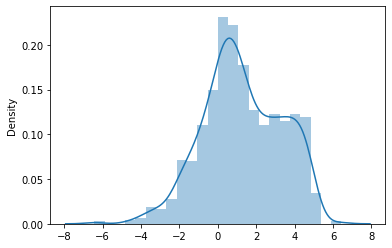

In [26]:
sns.distplot(np.vstack((xsample0, xsample1)))

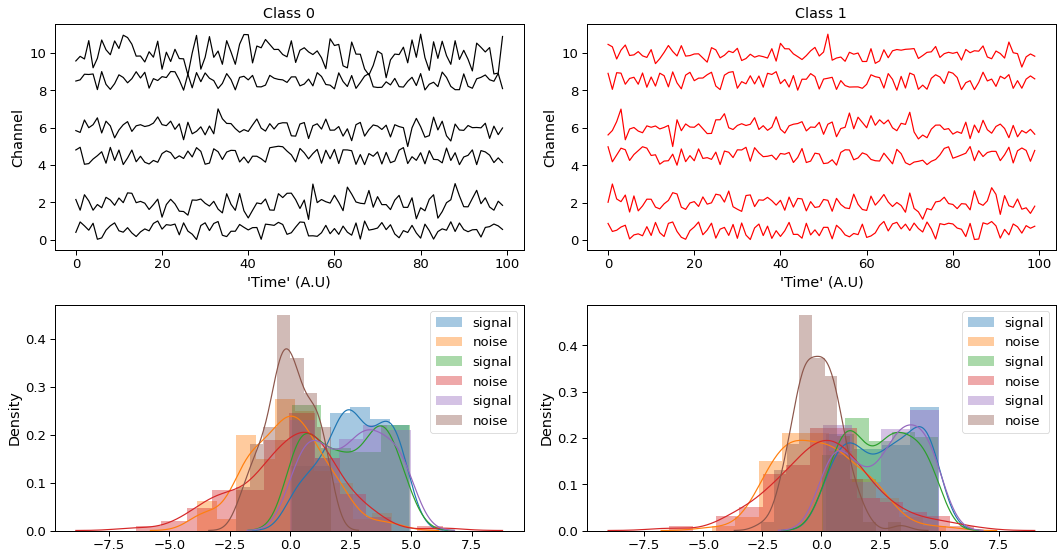

In [27]:
sns.set_context("paper", font_scale=1.5)
fig, axs = plt.subplots(2, 2, figsize=(15, 8))
axs = axs.flat
ax = axs[0]
prev_max = 0
for i in range(len(xsample0)):
    y = xsample0[i, :]
    ax.plot(2 * np.r_[i] + y / np.max(y), "k", label="class 0")
    prev_max += np.max(y)
ax.set_title("Class 0")
ax.set_ylabel("Channel")
ax.set_xlabel("'Time' (A.U)")

ax = axs[1]
prev_max = 0
for i in range(len(xsample1)):
    y = xsample1[i, :]
    ax.plot(2 * np.r_[i] + y / np.max(y), "r", label="class 1")
    prev_max += np.max(y)
ax.set_title("Class 1")
ax.set_ylabel("Channel")
ax.set_xlabel("'Time' (A.U)")

ax = axs[2]
for i in range(len(xsample0)):
    y = xsample0[i, :]
    if i % 2 != 0:
        label = "noise"
    else:
        label = "signal"
    sns.distplot(y, ax=ax, label=label)
ax.legend()

ax = axs[3]
for i in range(len(xsample1)):
    y = xsample1[i, :]
    if i % 2 != 0:
        label = "noise"
    else:
        label = "signal"
    sns.distplot(y, ax=ax, label=label)
ax.legend()

fig.tight_layout()

# Setup Classifiers

In [22]:
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.python.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.python.client import device_lib

physical_devices = tf.config.list_physical_devices("GPU")
# tf.config.experimental.set_memory_growth(physical_devices[0], True)
print("GPUs: ", len(tf.config.experimental.list_physical_devices("GPU")))

# CNN if tensorflow is installed
# Build CNN model
n_classes = 1


def _build_cnn():

    model = models.Sequential()
    model.add(
        layers.Conv2D(
            32,
            (2, 2),
            activation="relu",
            input_shape=(n_chs, n_samples, 1),
            padding="same",
        )
    )
    model.add(layers.MaxPooling2D((2, 2), padding="same"))
    model.add(layers.Conv2D(32, (2, 2), activation="relu", padding="same"))
    model.add(layers.MaxPooling2D((2, 2), padding="same"))
    model.add(layers.Conv2D(64, (2, 2), activation="relu", padding="same"))
    model.add(layers.Flatten())
    model.add(layers.Dense(64, activation="relu"))
    model.add(layers.Dense(n_classes, activation="sigmoid"))

    model.compile(
        optimizer="adam",
        loss="binary_crossentropy",
        metrics=[
            "accuracy",
            #                  tf.keras.metrics.AUC(multi_label=False)
        ],
    )
    return model

GPUs:  1


In [62]:
# from tensorflow.compat.v1 import ConfigProto
# from tensorflow.compat.v1 import InteractiveSession

# config = ConfigProto()
# config.gpu_options.allow_growth = True
# session = InteractiveSession(config=config)

In [63]:
model = (KerasClassifier(_build_cnn, verbose=0),)

print(model)

(<tensorflow.python.keras.wrappers.scikit_learn.KerasClassifier object at 0x7fe3cc33d760>,)


In [23]:
## Setup for run
names = {
    #     "Log. Reg": "blue",
    #     "Lin. SVM": "firebrick",
    #     "SVM": "purple",
    #     "kNN": "black",
    #     "RF": "#f86000",
    #     "MLP": "green",
    #     "cnn": "magenta",
    #     "Sporf": "red",
    "xgb": "black",
    #     "MT-MORF": "orange",
}

ncores = -1
n_est = 100  # number of estimators
random_state = 0

classifiers = [
    LogisticRegression(random_state=random_state, n_jobs=ncores, solver="liblinear"),
    LinearSVC(),
    SVC(C=1.0, kernel="rbf", gamma="auto", random_state=random_state),
    KNeighborsClassifier(3, n_jobs=ncores),
    RandomForestClassifier(n_estimators=n_est, max_features="auto", n_jobs=ncores),
    MLPClassifier(
        hidden_layer_sizes=(n_est,), random_state=random_state, max_iter=1000
    ),
    KerasClassifier(_build_cnn, verbose=0),
    rerfClassifier(
        projection_matrix="RerF",
        max_features="auto",
        n_jobs=ncores,
        n_estimators=n_est,
        oob_score=False,
        random_state=random_state,
    ),
    #     GradientBoostingClassifier(n_estimators=n_est,
    #                                random_state=random_state),
    #     rerfClassifier(
    #         projection_matrix="S-Rerf",
    #         max_features="auto",
    #         n_jobs=ncores,
    #         n_estimators=n_est,
    #         oob_score=False,
    #         random_state=0,
    #         image_height=n_chs,
    #         image_width=n_samples,
    #         patch_height_max=2,
    #         patch_height_min=1,
    #         patch_width_max=20,
    #         patch_width_min=5,
    #     ),
    rerfClassifier(
        projection_matrix="MT-MORF",
        max_features="auto",
        n_jobs=ncores,
        n_estimators=n_est,
        oob_score=False,
        random_state=random_state,
        image_height=n_chs,
        image_width=n_samples,
        patch_height_max=2,
        patch_height_min=1,
        patch_width_max=20,
        patch_width_min=5,
    ),
]

In [65]:
runList = [
    (n, clf, run)
    for n in ns
    for clf in zip(classifiers, [key for key in names])
    for run in range(num_runs)
]
print(
    f"About to run {len(runList)} clf experiments: "
    f"sample size: {n_samples}, number channels: {n_chs}, "
    f"n_trials: {n_trials}, noise dim: {noise_dim}"
)

About to run 50 clf experiments: sample size: 100, number channels: 6, n_trials: 1000, noise dim: 3


# Run Classification Experiment and Compare

In [10]:
fname = (
    study_path
    / f"mtorfexp_snrfactor={snr_factor}_samplesize={n_samples}_ntrials={n_trials}_noisedim={noise_dim}.csv"
)

print(fname)

/home/adam2392/hdd/Dropbox/morf-study/derivatives/mtmorf-simulation/mtorfexp_snrfactor=1.0_samplesize=100_ntrials=1000_noisedim=3.csv


In [67]:
print(clf)

print(isinstance(clf[0], KerasClassifier))

(rerfClassifier(image_height=6, image_width=100, n_estimators=100, n_jobs=-1,
               patch_height_max=2, patch_width_max=20, patch_width_min=5,
               projection_matrix='MT-MORF', random_state=0), 'MT-MORF')
False


In [69]:
overwrite = False

# Train each classifier on each dataset size, then test
# Prep output file:
if not Path(fname).exists() or overwrite:
    f = open(fname, "w+")
    f.write("classifier,n,Lhat,trainTime,testTime,iterate\n")
    f.flush()
else:
    f = open(fname, "a")

for n, clf, iteration in tqdm(runList):
    X_train, Y_train, X_test, Y_test = generate_data(
        n_chs, n_samples, n_trials, ns, data_dim, noise_dim, test_size, snr_factor
    )

    if X_train.ndim == 3:
        X_train = X_train.reshape(-1, X_train.shape[-1]).T
    if X_test.ndim == 3:
        X_test = X_test.reshape(-1, X_test.shape[-1]).T
    X = X_train[:n]
    y = Y_train[:n]

    # training start time and end time
    trainStartTime = time.time()

    if isinstance(clf[0], KerasClassifier):
        X = X.reshape(-1, n_chs, n_samples, 1)
        X_test = X_test.reshape(-1, n_chs, n_samples, 1)
    # train_data = tf.data.Dataset.from_tensor_slices((X, y))
    # valid_data = tf.data.Dataset.from_tensor_slices((X_test, Y_test))

    clf[0].fit(X, y)
    #   clf[0].fit(train_data, epochs=10, validation_data=valid_data)
    trainEndTime = time.time()
    trainTime = trainEndTime - trainStartTime

    # testing start time and end time
    testStartTime = time.time()
    out = clf[0].predict(X_test)
    testEndTime = time.time()
    testTime = testEndTime - testStartTime

    # mean-error on the test set
    lhat = np.mean(np.not_equal(out, Y_test).astype(int))
    ####("variable,Lhat,trainTime,testTime,iterate")

    clf_id = clf[1]
    outputstr_row = (
        f"{clf_id}, {n}, {lhat:2.9f}, {trainTime:2.9f}, {testTime:2.9f}, {iteration}\n"
    )
    f.write(outputstr_row)
    f.flush()

f.close()

100%|██████████| 50/50 [03:51<00:00,  4.63s/it]


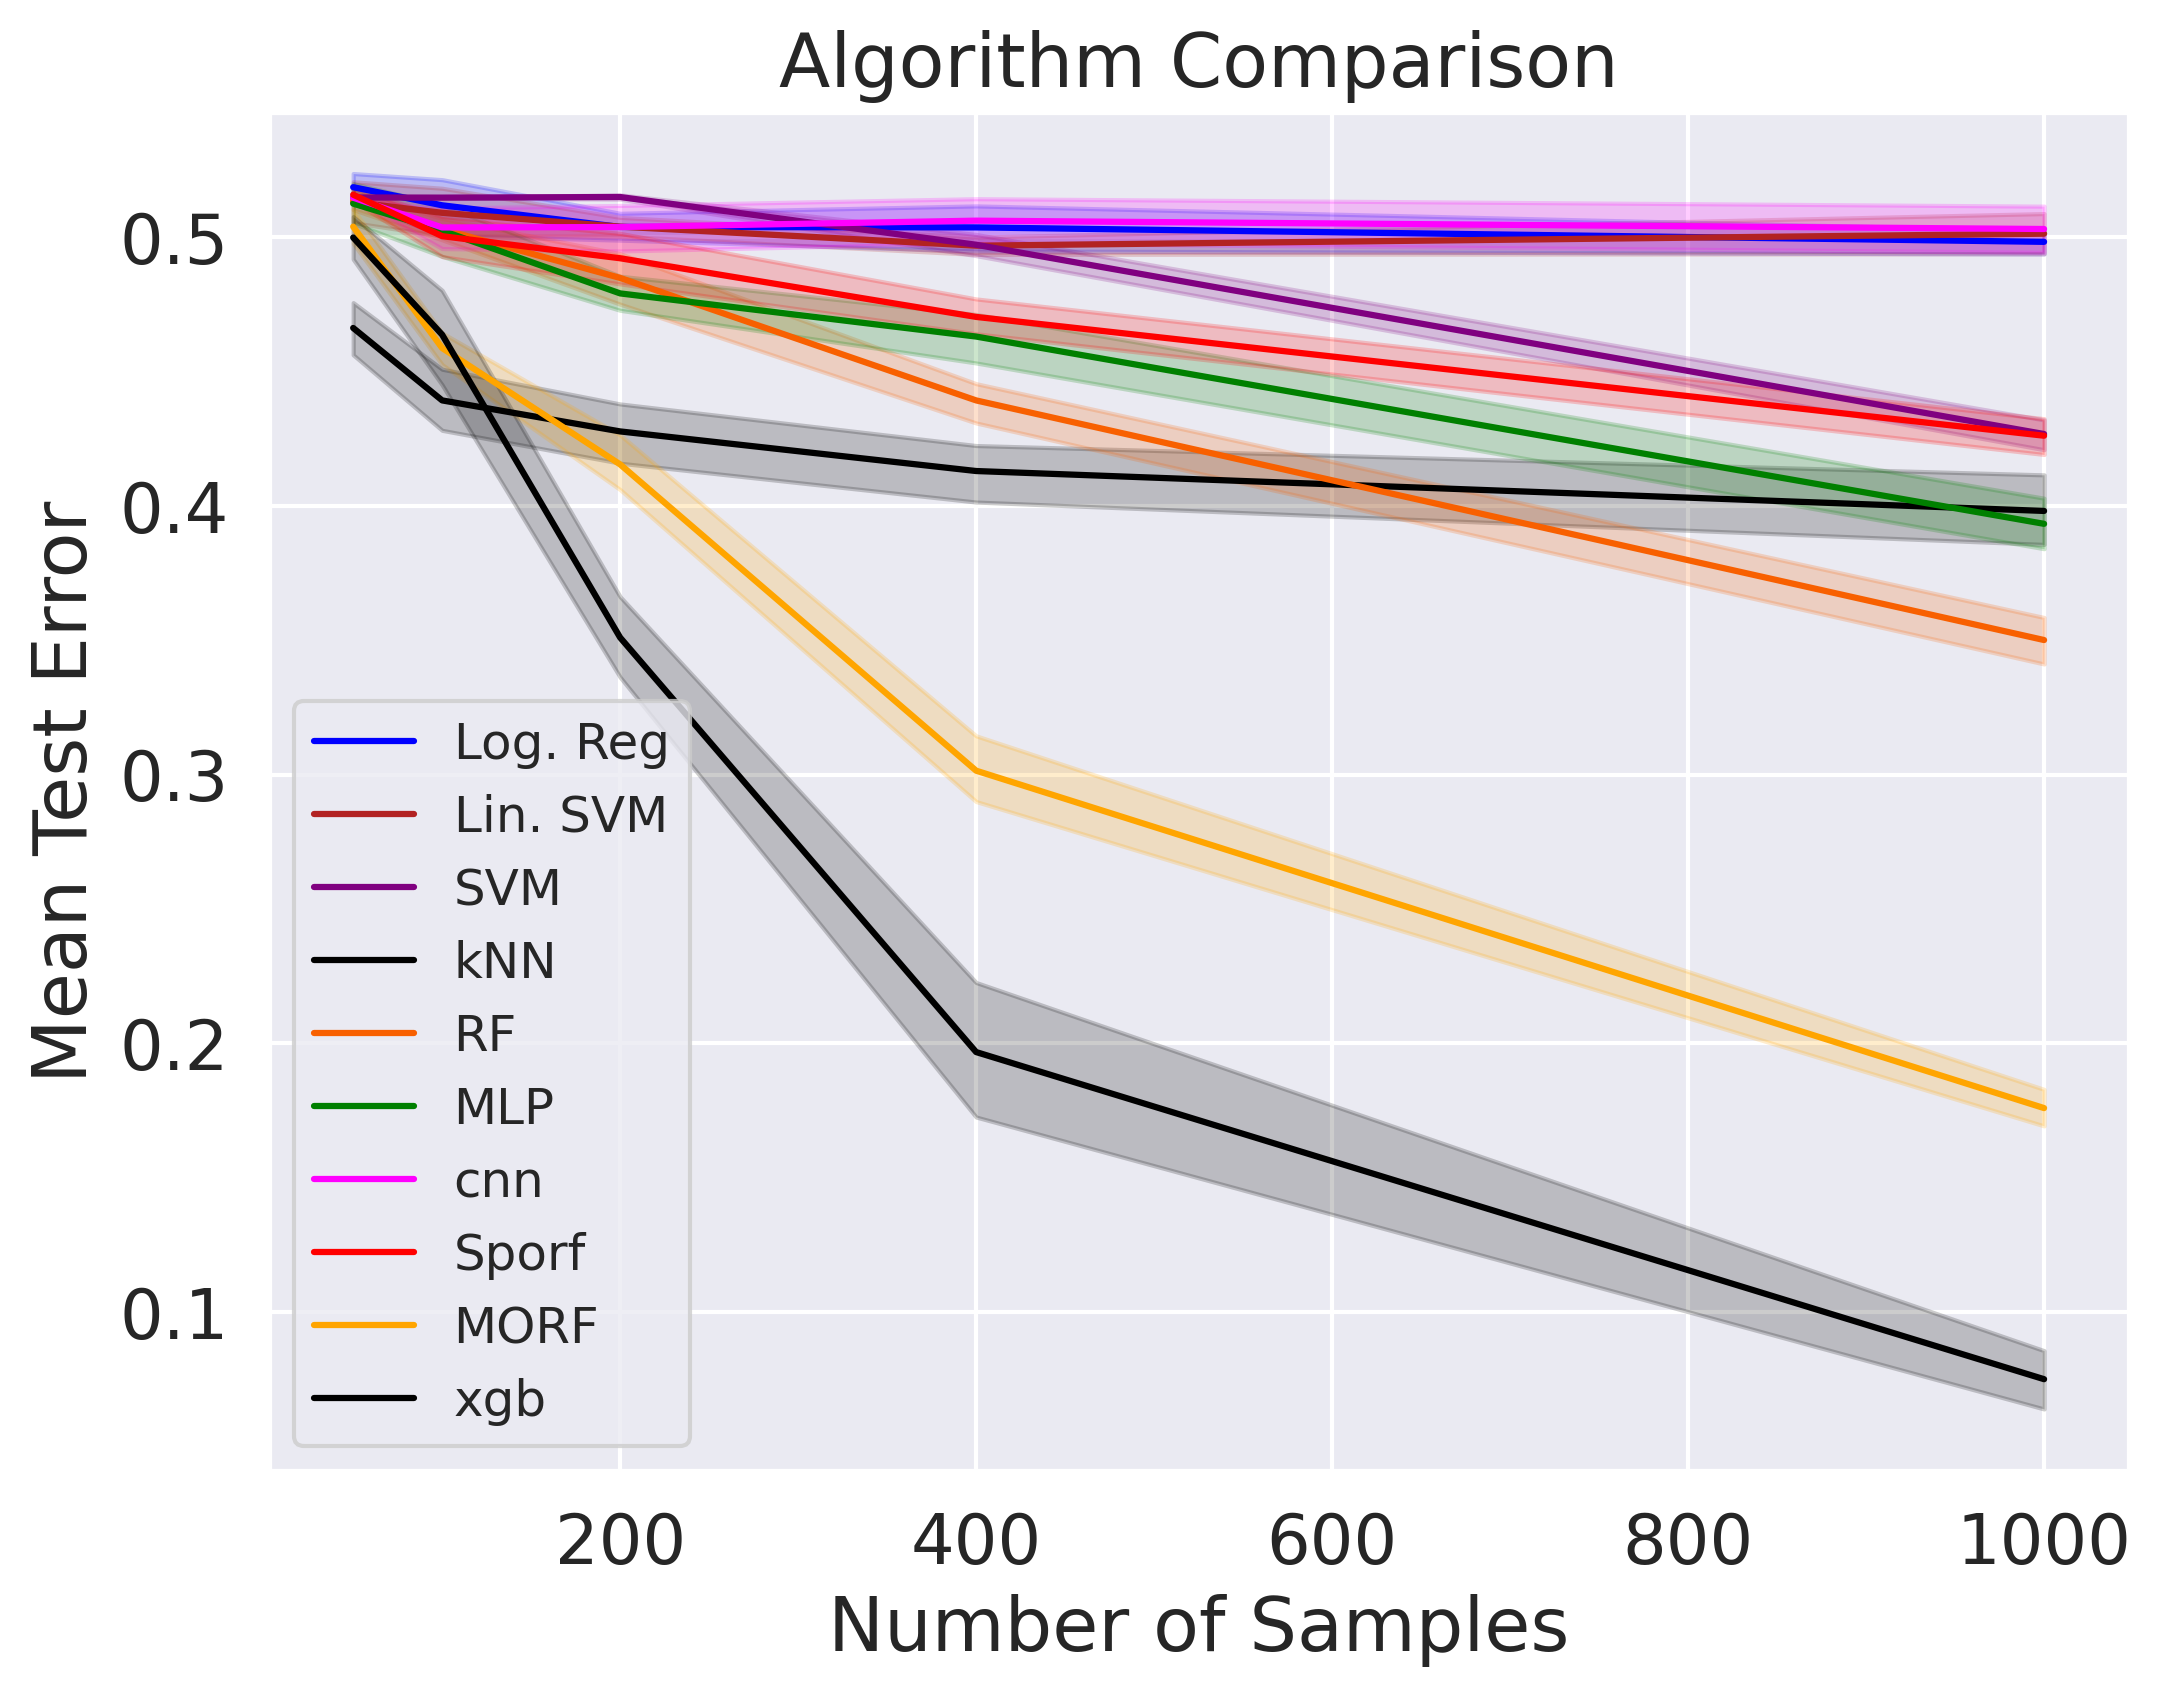

In [11]:
dat = pd.read_csv(fname)

dat["classifier"] = dat["classifier"].replace({"MT-MORF": "MORF"})

# dat = dat[dat["classifier"] != "xgb"]

names = {
    "Log. Reg": "blue",
    "Lin. SVM": "firebrick",
    "SVM": "purple",
    "kNN": "black",
    "RF": "#f86000",
    "MLP": "green",
    "cnn": "magenta",
    "Sporf": "red",
    "xgb": "black",
    "MORF": "orange",
}

sns.set(
    style="darkgrid", rc={"figure.figsize": [12, 8], "figure.dpi": 300}, font_scale=1.5
)
fig, ax = plt.subplots(figsize=(8, 6))

sns.lineplot(
    x="n",
    y="Lhat",
    hue="classifier",
    data=dat,  # [dat["classifier"] == "MT-MORF"],
    ax=ax,
    palette=names,
)

plt.legend(loc="best", prop={"size": 12})
plt.title("Algorithm Comparison")
plt.ylabel("Mean Test Error")
plt.xlabel("Number of Samples")
plt.savefig(
    study_path
    / f"morf_experiment_discontiguous_multivariategaussian_snrfactor-{snr_factor}_samplesize={n_samples}_ntrials={n_trials}_noisedim={noise_dim}.pdf",
    dpi=300,
    format="pdf",
)
plt.show()

# Compare Classifications on Increasing Noise Dimensionality

In [85]:
def generate_train_test(
    noise_dim, n_samples, n_chs, n_trials, indices=None, snr_factor=1
):
    # make sure dimensionality is integer
    noise_dim = int(noise_dim)

    # initialize data structures for train/test data
    X_train = np.empty(shape=(0, n_chs, n_samples))
    Y_train = np.empty(shape=(0))
    X_test, Y_test = np.empty(shape=(0, n_chs, n_samples)), np.empty(shape=(0))

    y = []
    X = []

    mu = np.array([1, 5, 10])
    #     mu = np.zeros((3,))
    # first class
    cov1 = np.array([[1.5, 0, 0], [0, 1.25, 0], [0, 0, 1.0]])

    # second class
    cov2 = np.array([[1.5, 1, 1], [1, 1.25, 1], [1, 1, 1.0]])

    off_diag_idx = np.where(~np.eye(cov2.shape[0], dtype=bool))
    cov2[off_diag_idx] *= snr_factor

    # generate correlated multi-variate time series
    for i in range(n_trials):
        _x = _generate_redundant_data(
            noise_dim=noise_dim,
            n_samples=n_samples,
            mu=mu,
            cov=cov1,
            permutation_strategy=permutation_strategy,
            indices=indices,
        )
        X.append(_x)
        y.append(0)
    for i in range(n_trials):
        _x = _generate_redundant_data(
            noise_dim=noise_dim,
            n_samples=n_samples,
            mu=mu,
            cov=cov2,
            permutation_strategy=permutation_strategy,
            indices=indices,
        )

        X.append(_x)
        y.append(1)
    X = np.array(X)
    y = np.array(y)

    # perform training test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=42
    )
    #     X_train = np.vstack((X_train, _X_train))
    #     Y_train = np.hstack((Y_train, _y_train))
    #     X_test = np.vstack((X_test, _X_test))
    #     Y_test = np.hstack((Y_test, _y_test))

    X_train = X_train.reshape(X_train.shape[0], -1)
    X_test = X_test.reshape(X_test.shape[0], -1)
    return X_train, y_train, X_test, y_test

In [86]:
permutation_strategy = "random"

In [24]:
noise_dims = np.linspace(3, 30, 10)

In [25]:
runList = [
    (n, run)
    for n in noise_dims  #                    for clf in zip(classifiers,
    #                                   [key for key in names])\
    for run in range(num_runs)
]
print(
    f"About to run {len(runList)} clf experiments: "
    f"sample size: {n_samples}, number channels: {n_chs}, "
    f"n_trials: {n_trials}, noise dim: {noise_dim}"
)

print(num_runs)

About to run 100 clf experiments: sample size: 100, number channels: 6, n_trials: 1000, noise dim: 3
10


In [26]:
fname = (
    study_path
    / f"mtorfexp_snrfactor={snr_factor}_samplesize={n_samples}_ntrials={n_trials}_noisedim={noise_dims}.csv"
)

print(fname)

/home/adam2392/hdd/Dropbox/morf-study/derivatives/mtmorf-simulation/mtorfexp_snrfactor=1.0_samplesize=100_ntrials=1000_noisedim=[ 3.  6.  9. 12. 15. 18. 21. 24. 27. 30.].csv


In [ ]:
overwrite = True

# Train each classifier on each dataset size, then test
# Prep output file:
if not Path(fname).exists() or overwrite:
    f = open(fname, "w+")
    f.write("classifier,n,Lhat,trainTime,testTime,iterate\n")
    f.flush()
else:
    f = open(fname, "a")

for jdx, (n, iteration) in enumerate(tqdm(runList)):
    xtrain, ytrain = [], []
    xtest, ytest = [], []
    for noise_dim in noise_dims:
        n_trials = 500
        n_chs = int(data_dim + noise_dim)

        indices = np.random.choice(np.arange(n_chs), size=n_chs, replace=False)
        assert len(np.unique(indices)) == n_chs
        X_train, Y_train, X_test, Y_test = generate_train_test(
            noise_dim,
            n_samples,
            n_chs,
            n_trials,
            indices=indices,
            snr_factor=snr_factor,
        )
        xtrain.append(X_train)
        ytrain.append(Y_train)
        xtest.append(X_test)
        ytest.append(Y_test)

    idx = int(np.argwhere(noise_dims == n))
    n_chs = int(data_dim + n)

    ## Setup for run
    names = {
        "Log. Reg": "blue",
        "Lin. SVM": "firebrick",
        "SVM": "purple",
        "kNN": "black",
        "RF": "#f86000",
        "MLP": "green",
        "cnn": "magenta",
        "Sporf": "red",
        "xgb": "black",
        "MORF": "orange",
    }

    ncores = -1
    num_runs = 1
    n_est = 100  # number of estimators / hidden layers

    classifiers = [
        LogisticRegression(random_state=0, n_jobs=ncores, solver="liblinear"),
        LinearSVC(),
        SVC(C=1.0, kernel="rbf", gamma="auto", random_state=0),
        KNeighborsClassifier(3, n_jobs=ncores),
        RandomForestClassifier(n_estimators=n_est, max_features="auto", n_jobs=ncores),
        MLPClassifier(hidden_layer_sizes=(n_est,), random_state=0, max_iter=1000),
        KerasClassifier(_build_cnn, verbose=0),
        rerfClassifier(
            projection_matrix="RerF",
            max_features="auto",
            n_jobs=ncores,
            n_estimators=n_est,
            oob_score=False,
            random_state=0,
        ),
        GradientBoostingClassifier(n_estimators=n_est, random_state=random_state),
        rerfClassifier(
            projection_matrix="MT-MORF",
            max_features="auto",
            n_jobs=ncores,
            n_estimators=n_est,
            oob_score=False,
            random_state=0,
            image_height=n_chs,
            image_width=n_samples,
            patch_height_max=3,
            patch_height_min=1,
            patch_width_max=20,
            patch_width_min=5,
        ),
    ]

    for clf in zip(classifiers, [key for key in names]):
        X = xtrain[idx]  # .flatten()
        y = ytrain[idx]  # .flatten()
        Y_test = ytest[idx]  # .flatten()
        X_test = xtest[idx]  # .flatten()
        #     X = X_train[:n]
        #     y = Y_train[:n]

        # training start time and end time
        trainStartTime = time.time()

        if isinstance(clf[0], KerasClassifier):
            X = X.reshape(-1, n_chs, n_samples, 1)
            X_test = X_test.reshape(-1, n_chs, n_samples, 1)

        clf[0].fit(X, y)
        trainEndTime = time.time()
        trainTime = trainEndTime - trainStartTime

        # testing start time and end time
        testStartTime = time.time()
        out = clf[0].predict(X_test)
        testEndTime = time.time()
        testTime = testEndTime - testStartTime

        # mean-error on the test set
        lhat = np.mean(np.not_equal(out, Y_test).astype(int))
        ####("variable,Lhat,trainTime,testTime,iterate")

        clf_id = clf[1]
        outputstr_row = f"{clf_id}, {n}, {lhat:2.9f}, {trainTime:2.9f}, {testTime:2.9f}, {iteration}\n"
        f.write(outputstr_row)
        f.flush()
f.close()

100%|██████████| 100/100 [56:07<00:00, 33.67s/it]


,classifier,n,Lhat,trainTime,testTime,iterate


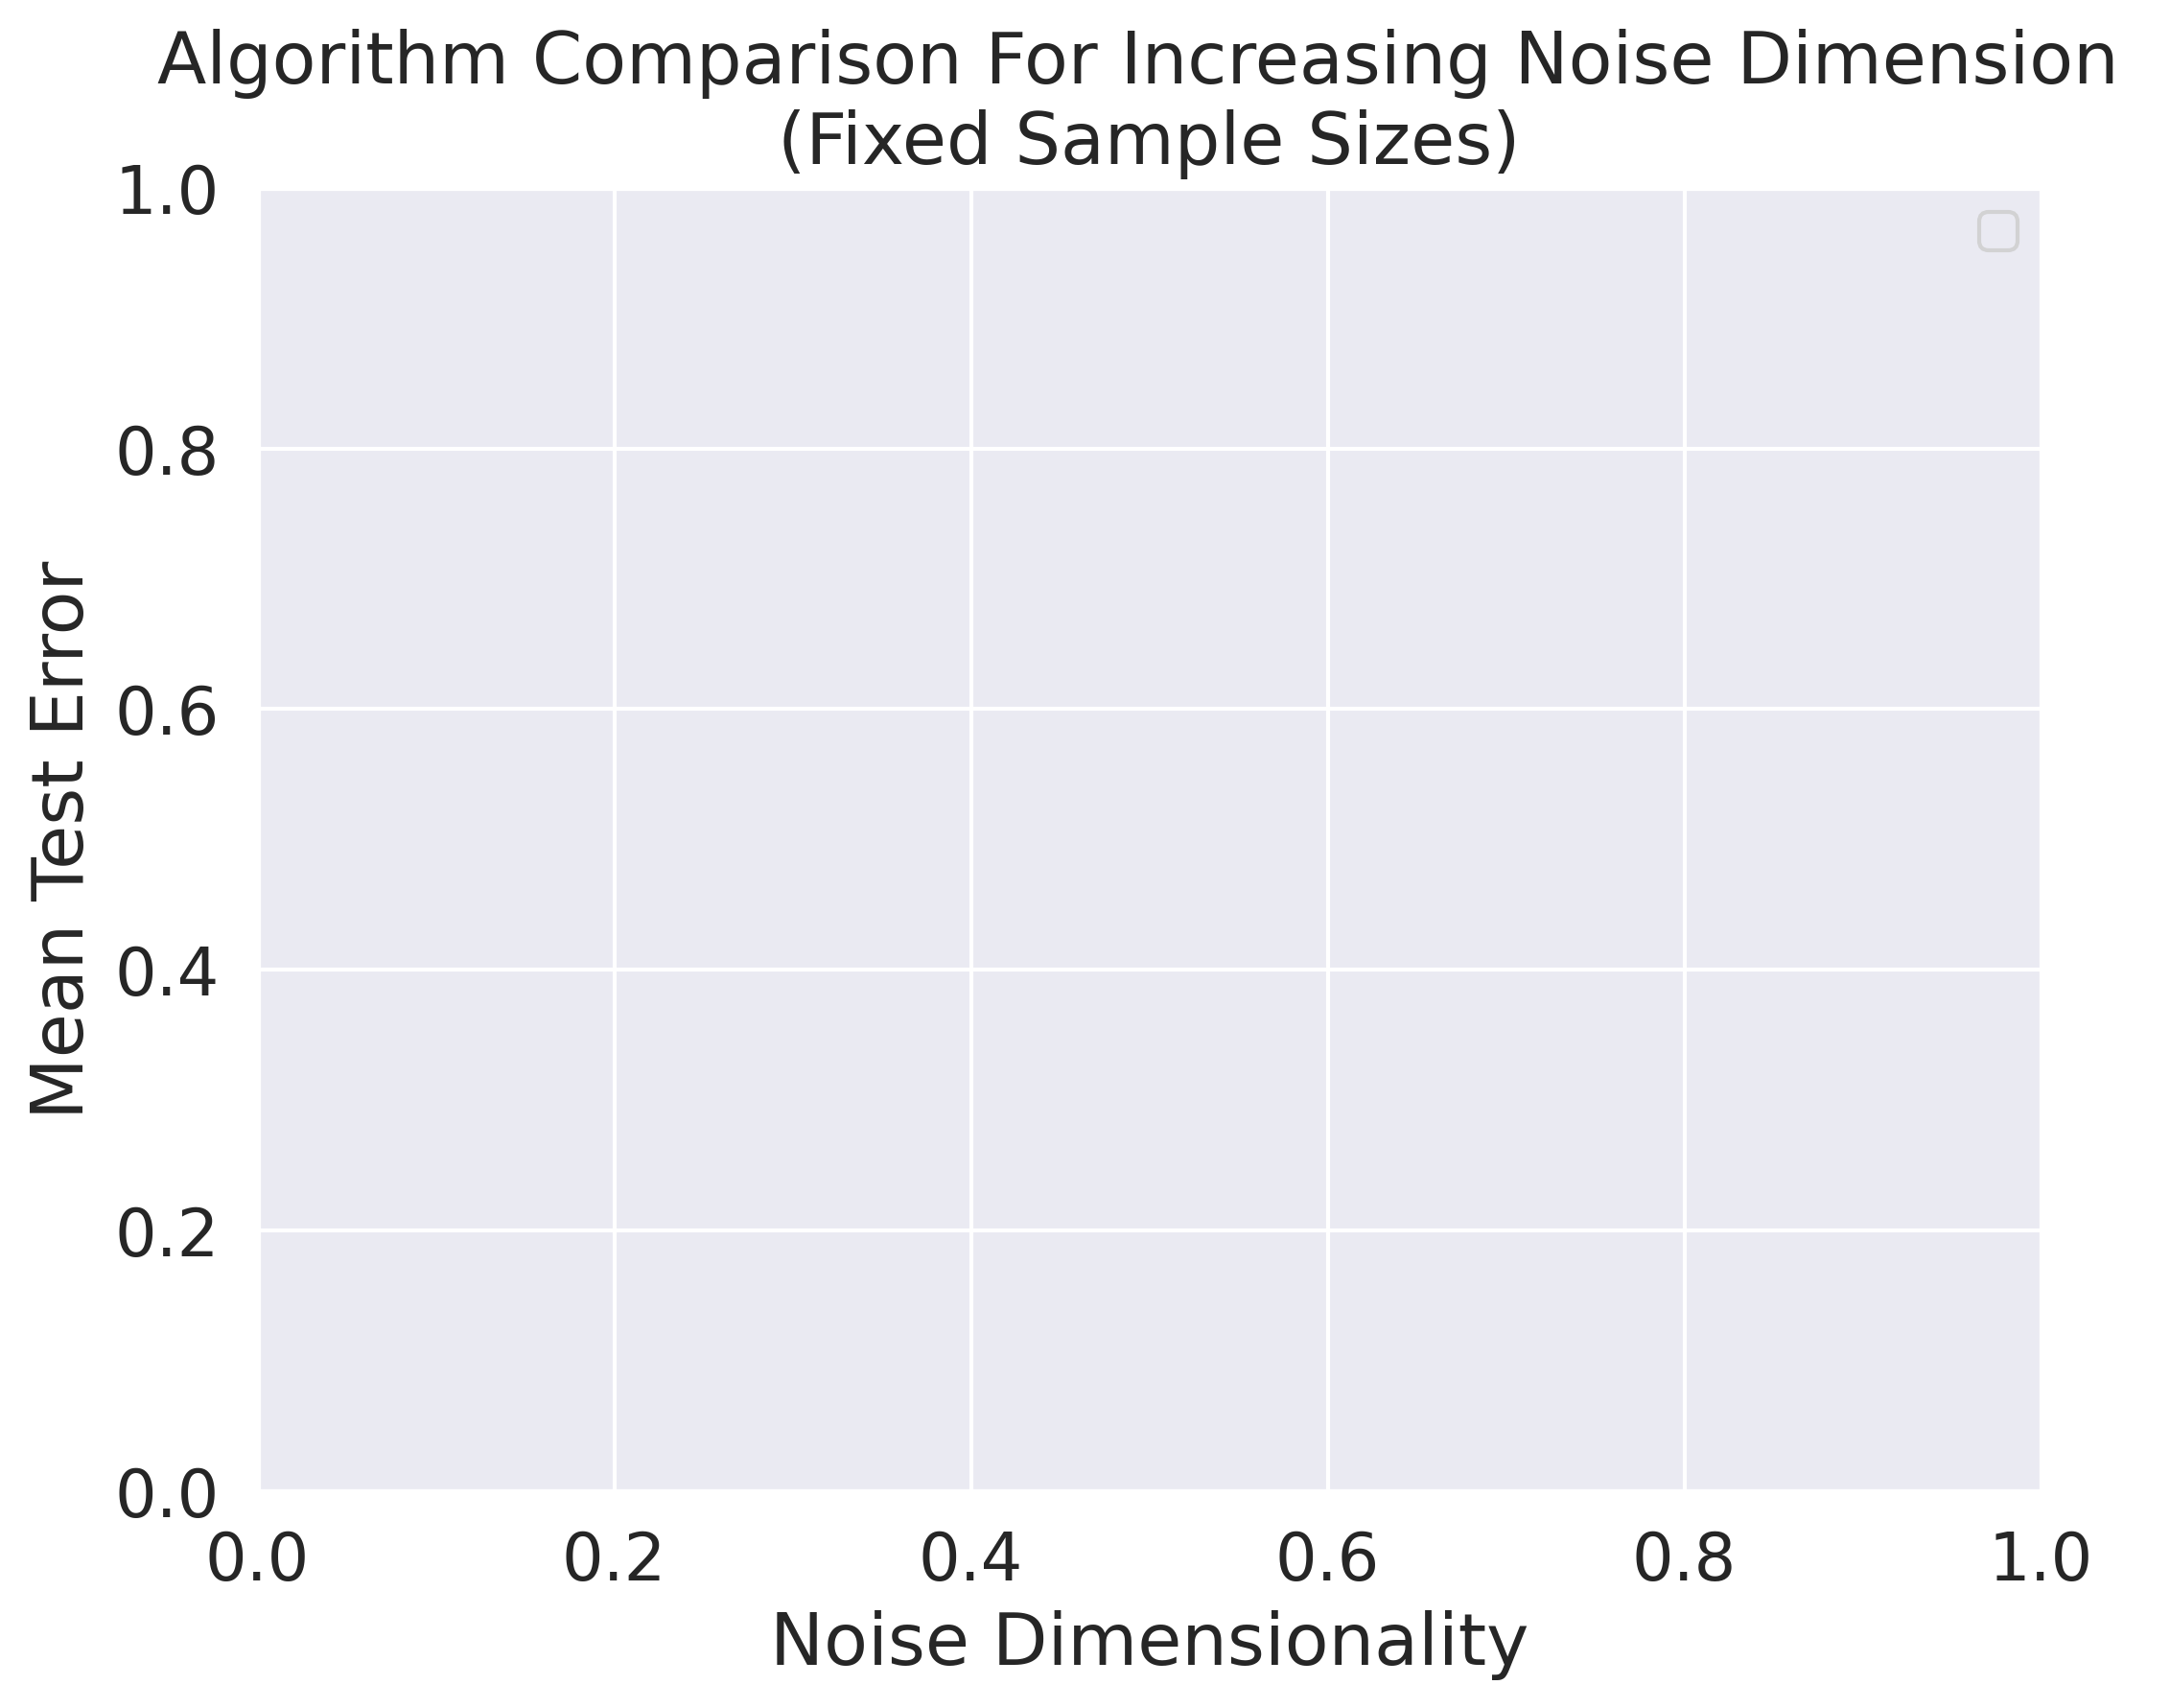

In [27]:
dat = pd.read_csv(fname)
display(dat)
# dat = dat[dat["classifier"] != "xgb"]

names = {
    "Log. Reg": "blue",
    "Lin. SVM": "firebrick",
    "SVM": "purple",
    "kNN": "black",
    "RF": "#f86000",
    "MLP": "green",
    "cnn": "magenta",
    "Sporf": "red",
    "xgb": "black",
    "MORF": "orange",
}

sns.set(
    style="darkgrid", rc={"figure.figsize": [12, 8], "figure.dpi": 300}, font_scale=1.5
)
fig, ax = plt.subplots(figsize=(8, 6))

sns.lineplot(
    x="n",
    y="Lhat",
    hue="classifier",
    data=dat,  # [dat["classifier"] == "MT-MORF"],
    ax=ax,
    palette=names,
)

# for key in names.keys():
#     grp = d1[d1['classifier'] == key]
#     ax = grp.plot(ax=ax, kind='line', x='n', y='Lhat', label=key, \
#             c = names[key], alpha =0.65)
# ax.set_yscale('log')

plt.legend(loc="best", prop={"size": 12})
plt.title("Algorithm Comparison For Increasing Noise Dimension \n(Fixed Sample Sizes)")
plt.ylabel("Mean Test Error")
plt.xlabel("Noise Dimensionality")
plt.savefig(
    study_path
    / f"morf_experiment_trunk_increasing_noisedims_snrfactor-{snr_factor}_samplesize={n_samples}_ntrials={n_trials}_noisedim={noise_dim}.pdf",
    dpi=300,
    format="pdf",
)
plt.show()

# Discussion

As can be seen from simulations, the MORF variants perform better in terms of classification on out-of-sample test set, and also is more robust to increasing noise dimensions in the dataset, which is important for scientific discovery in high-dimensional datasets, where there might only be a small part of the data that has signal. In an ideal world, we would know which part of the dataset has that signal, but if not, then a robust classifier can help us.

# Compare Effect of Covariance Magnitude

Multiply the off-diagonal covariances by a constant factor until the two multivariate distributions are almost the same. As the constant factor is closer to 0, it should produce chance-level classification for all classifiers, while slowly improving as the constant factor gets larger.

In [71]:
# length of data sequence
ns = np.array([50, 100, 200, 400, 1000])

# assume you can train on half trials and
# test on half the trials
test_size = 0.5

# number of samples
n_samples = 100

# simulated data parameters
n_trials = 1000

# dimensionality of data and noise
data_dim = 3
noise_dim = 3
n_chs = data_dim + noise_dim

# data mean vector
mu = np.zeros((data_dim,))

# permutation strategy
permutation_strategy = "alternate"

In [72]:
## Setup for run
names = {
    "Log. Reg": "blue",
    "Lin. SVM": "firebrick",
    "SVM": "purple",
    "kNN": "black",
    "RF": "#f86000",
    "MLP": "green",
    "cnn": "magenta",
    "Sporf": "red",
    "MT-MORF": "orange",
}

ncores = -1
num_runs = 10
n_est = 100  # number of estimators
random_state = 0

classifiers = [
    LogisticRegression(random_state=random_state, n_jobs=ncores, solver="liblinear"),
    LinearSVC(),
    SVC(C=1.0, kernel="rbf", gamma="auto", random_state=random_state),
    KNeighborsClassifier(3, n_jobs=ncores),
    RandomForestClassifier(n_estimators=n_est, max_features="auto", n_jobs=ncores),
    MLPClassifier(
        hidden_layer_sizes=(n_est,), random_state=random_state, max_iter=1000
    ),
    KerasClassifier(_build_cnn, verbose=0),
    rerfClassifier(
        projection_matrix="RerF",
        max_features="auto",
        n_jobs=ncores,
        n_estimators=n_est,
        oob_score=False,
        random_state=random_state,
    ),
    #     GradientBoostingClassifier(n_estimators=n_est,
    #                                random_state=random_state),
    #     rerfClassifier(
    #         projection_matrix="S-Rerf",
    #         max_features="auto",
    #         n_jobs=ncores,
    #         n_estimators=n_est,
    #         oob_score=False,
    #         random_state=0,
    #         image_height=n_chs,
    #         image_width=n_samples,
    #         patch_height_max=2,
    #         patch_height_min=1,
    #         patch_width_max=20,
    #         patch_width_min=5,
    #     ),
    rerfClassifier(
        projection_matrix="MT-MORF",
        max_features="auto",
        n_jobs=ncores,
        n_estimators=n_est,
        oob_score=False,
        random_state=random_state,
        image_height=n_chs,
        image_width=n_samples,
        patch_height_max=2,
        patch_height_min=1,
        patch_width_max=20,
        patch_width_min=5,
    ),
]

In [73]:
runList = [
    (n, clf, run)
    for n in ns
    for clf in zip(classifiers, [key for key in names])
    for run in range(num_runs)
]
print(
    f"About to run {len(runList)} clf experiments: "
    f"sample size: {n_samples}, number channels: {n_chs}, "
    f"n_trials: {n_trials}, noise dim: {noise_dim}, over {num_runs} runs"
)

About to run 450 clf experiments: sample size: 100, number channels: 6, n_trials: 1000, noise dim: 3, over 10 runs


In [74]:
for idx, snr_factor in enumerate([1e-5, 0.1, 0.5, 0.8]):

    # Train each classifier on each dataset size, then test
    # Prep output file:
    fname = study_path / f"noisevar-5_mtorfexp_snrfactor={snr_factor}_samplesize={n_samples}_ntrials={n_trials}_noisedim={noise_dim}.csv"
    f = open(fname, "w+")
    f.write("classifier,n,Lhat,trainTime,testTime,iterate\n")
    f.flush()

    for n, clf, iteration in tqdm(runList):
        X_train, Y_train, X_test, Y_test = generate_train_test(
            noise_dim,
            n_samples,
            n_chs,
            n_trials,
            indices=None,
            snr_factor=snr_factor,
        )
        # print(clf)
        if X_train.ndim == 3:
            X_train = X_train.reshape(-1, X_train.shape[-1]).T
        if X_test.ndim == 3:
            X_test = X_test.reshape(-1, X_test.shape[-1]).T
        X = X_train[:n]
        y = Y_train[:n]

        trainStartTime = time.time()
        clf[0].fit(X, y)
        trainEndTime = time.time()
        trainTime = trainEndTime - trainStartTime

        testStartTime = time.time()
        out = clf[0].predict(X_test)
        testEndTime = time.time()
        testTime = testEndTime - testStartTime

        lhat = np.mean(np.not_equal(out, Y_test).astype(int))

        ####("variable,Lhat,trainTime,testTime,iterate")
        f.write(
            f"{clf[1]}, {n}, {lhat:2.9f}, {trainTime:2.9f}, {testTime:2.9f}, {iteration}\n"
        )
        f.flush()

    f.close()

 13%|█▎        | 60/450 [00:23<02:35,  2.51it/s]


ValueError: in user code:

    /home/adam2392/Documents/morf-demo/.venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:805 train_function  *
        return step_function(self, iterator)
    /home/adam2392/Documents/morf-demo/.venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:795 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /home/adam2392/Documents/morf-demo/.venv/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:1259 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /home/adam2392/Documents/morf-demo/.venv/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:2730 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /home/adam2392/Documents/morf-demo/.venv/lib/python3.8/site-packages/tensorflow/python/distribute/distribute_lib.py:3417 _call_for_each_replica
        return fn(*args, **kwargs)
    /home/adam2392/Documents/morf-demo/.venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:788 run_step  **
        outputs = model.train_step(data)
    /home/adam2392/Documents/morf-demo/.venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/training.py:754 train_step
        y_pred = self(x, training=True)
    /home/adam2392/Documents/morf-demo/.venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/base_layer.py:998 __call__
        input_spec.assert_input_compatibility(self.input_spec, inputs, self.name)
    /home/adam2392/Documents/morf-demo/.venv/lib/python3.8/site-packages/tensorflow/python/keras/engine/input_spec.py:234 assert_input_compatibility
        raise ValueError('Input ' + str(input_index) + ' of layer ' +

    ValueError: Input 0 of layer sequential_152 is incompatible with the layer: : expected min_ndim=4, found ndim=2. Full shape received: (None, 600)


In [76]:
for snr_factor in [1e-5, 0.1, 0.5, 0.8, 1.0]:
    fname = study_path / f"noisevar-5_mtorfexp_snrfactor={snr_factor}_samplesize={n_samples}_ntrials={n_trials}_noisedim={noise_dim}.csv"

    dat = pd.read_csv(fname)

    sns.set(
        style="darkgrid",
        rc={"figure.figsize": [12, 8], "figure.dpi": 300},
        font_scale=1.5,
    )
    fig, ax = plt.subplots(figsize=(8, 6))

    sns.lineplot(
        x="n",
        y="Lhat",
        hue="classifier",
        data=dat,  # [dat["classifier"] == "MT-MORF"],
        ax=ax,
        palette=names,
    )

    # for key in names.keys():
    #     grp = d1[d1['classifier'] == key]
    #     ax = grp.plot(ax=ax, kind='line', x='n', y='Lhat', label=key, \
    #             c = names[key], alpha =0.65)
    # ax.set_yscale('log')

    plt.legend(loc="best", prop={"size": 12})
    plt.title(f"Algorithm Comparison Covariance Factor {snr_factor}")
    plt.ylabel("Mean Test Error")
    plt.xlabel("Number of Training Samples")
    # plt.savefig('./s-rerf_impulse_experiment.pdf',dpi=300,format='pdf')
    plt.show()